# Cache-Augmented Generation

This notebook is a demonstration of **Cache-Augmented Generation** using:
- **Mistral** (`mistralai/Mistral-7B-Instruct-v0.1`)
- A `document.txt` file describing **YOU**.
- A simple **KV cache** mechanism with `DynamicCache`.

We’ll:
1. Load the model.
2. Preload `document.txt` into the cache.
3. Ask two questions, reusing the same cache.

Prerequisites:
1. A HuggingFace account
2. A .env file with your HuggingFace access token.
3. A document.txt file with sentences about yourself.

For this demo, I will be using my own document.txt and ask questions about myself (Ronan Takizawa)


### Imports and the Generate Function
We import the essential libraries (torch, transformers) and define the generate function. This function handles token-by-token generation, reusing the model’s past_key_values.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.cache_utils import DynamicCache
import os

# Minimal generate function for token-by-token generation
def generate(model, input_ids: torch.Tensor, past_key_values, max_new_tokens: int = 50) -> torch.Tensor:
    device = model.model.embed_tokens.weight.device
    origin_len = input_ids.shape[-1]
    input_ids = input_ids.to(device)
    output_ids = input_ids.clone()
    next_token = input_ids

    with torch.no_grad():
        for _ in range(max_new_tokens):
            out = model(
                input_ids=next_token,
                past_key_values=past_key_values,
                use_cache=True
            )
            logits = out.logits[:, -1, :]
            token = torch.argmax(logits, dim=-1, keepdim=True)
            output_ids = torch.cat([output_ids, token], dim=-1)
            past_key_values = out.past_key_values
            next_token = token.to(device)

            if model.config.eos_token_id is not None and token.item() == model.config.eos_token_id:
                break

    # Return just the newly generated part
    return output_ids[:, origin_len:]

### DynamicCache Setup
Initializing the DynamicCache mechanism for storing and reusing the model’s key/value states. It also provides a clean_up function to truncate any extra tokens appended by user queries.

In [ ]:
torch.serialization.add_safe_globals([DynamicCache])
torch.serialization.add_safe_globals([set])

def get_kv_cache(model, tokenizer, prompt: str) -> DynamicCache:
    # Encode prompt
    device = model.model.embed_tokens.weight.device
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    cache = DynamicCache()

    with torch.no_grad():
        _ = model(
            input_ids=input_ids,
            past_key_values=cache,
            use_cache=True
        )
    return cache

def clean_up(cache: DynamicCache, origin_len: int):
    # Remove any tokens appended to the original knowledge
    for i in range(len(cache.key_cache)):
        cache.key_cache[i] = cache.key_cache[i][:, :, :origin_len, :]
        cache.value_cache[i] = cache.value_cache[i][:, :, :origin_len, :]

### .env function logic

Defining logic to get Hugging Face Token to log inot Hugging Face and download the LLM.

In [ ]:
def get_env():
    env_dict = {}
    env_file = ".env" if os.path.exists(".env") else "env"
    if os.path.exists(env_file):
        with open(env_file, mode="r") as f:
            for line in f:
                key, value = line.strip().split("=")
                env_dict[key] = value.strip('"')
    else:
        print("No .env or env file found; HF_TOKEN may not be set.")
    return env_dict

env = get_env()
HF_TOKEN = env.get("HF_TOKEN", None)

# Global placeholders (if needed)
model_name = None
model = None
tokenizer = None
rand_seed = None

print("Environment and imports are set.")

Environment and imports are set.


### Load Mistral
We’ll load the `mistralai/Mistral-7B-Instruct-v0.1` model in full precision (FP16 on GPU if available).


In [ ]:
model_name = "mistralai/Mistral-7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name, token=HF_TOKEN, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
    trust_remote_code=True,
    token=HF_TOKEN
)
device = "cuda"
model.to(device)
print(f"Loaded {model_name}.")

### Create a Knowledge Prompt from `document.txt`
We read the file, build a short system/user prompt, and call `get_kv_cache`.

In [ ]:
if not os.path.exists("document.txt"):
    raise FileNotFoundError("Please create a `document.txt` with info about Ronan Takizawa.")

with open("document.txt", "r", encoding="utf-8") as f:
    doc_text = f.read()

system_prompt = f"""
<|system|>
You are an assistant who provides concise factual answers.
<|user|>
Context:
{doc_text}
Question:
""".strip()

# Build the cache
ronan_cache = get_kv_cache(model, tokenizer, system_prompt)
origin_len = ronan_cache.key_cache[0].shape[-2]
print("KV cache built.")

KV cache built.


### Ask Questions Reusing the Cache
We use the same knowledge (no real-time retrieval).

In [ ]:
# 1st query
question1 = "Who is Ronan Takizawa?"
clean_up(ronan_cache, origin_len)
input_ids_q1 = tokenizer(question1 + "\n", return_tensors="pt").input_ids.to(device)
gen_ids_q1 = generate(model, input_ids_q1, ronan_cache)
answer1 = tokenizer.decode(gen_ids_q1[0], skip_special_tokens=True)
print("Q1:", question1)
print("A1:", answer1)

Q1: Who is Ronan Takizawa?
A1: 
Answer: Ronan Takizawa is a Colorado College computer science student, cybersecurity researcher, and tech content creator with over 100,000 followers across social media platforms. He has built several applications and systems using


In [ ]:
# 2nd query
question2 = "What are his main projects?"
clean_up(ronan_cache, origin_len)
input_ids_q2 = tokenizer(question2 + "\n", return_tensors="pt").input_ids.to(device)
gen_ids_q2 = generate(model, input_ids_q2, ronan_cache)
answer2 = tokenizer.decode(gen_ids_q2[0], skip_special_tokens=True)
print("Q2:", question2)
print("A2:", answer2)

Q2: What are his main projects?
A2: 
Answer: Ronan Takizawa's main projects include Punch Analytics, Noname, TeleSpeech, and the website automation system for the Ireland-Japan Chamber of Commerce.


In [ ]:
# Save the cache to disk
clean_up(ronan_cache, origin_len)
cache_dir = "cag_cache"
os.makedirs(cache_dir, exist_ok=True)

# Save the KV cache
torch.save(ronan_cache, os.path.join(cache_dir, "ronan_knowledge.cache"))


In [ ]:
# Load cache to prove context is preserved for multiple sessions
loaded_cache = torch.load(os.path.join(cache_dir, "ronan_knowledge.cache"))

question3 = "What technologies has he worked with?"
input_ids_q3 = tokenizer(question3 + "\n", return_tensors="pt").input_ids.to(device)
gen_ids_q3 = generate(model, input_ids_q3, loaded_cache)
answer3 = tokenizer.decode(gen_ids_q3[0], skip_special_tokens=True)
print("Q3:", question3)
print("A3:", answer3)

Q3: What technologies has he worked with?
A3: 
Answer: Ronan Takizawa has worked with Python, TypeScript, Rust, Java, Shell, SQL, React, NodeJS, MongoDB, Docker, Kubernetes, AWS, GCP, Firebase, Open


### Done!
This minimal notebook **preloads** knowledge, then answers queries using the **same** cached context.

# Performance Comparison of RAG vs CAG

🚀 RAG vs CAG Performance Comparison
🔄 Encoding documents for RAG...
✅ RAG setup complete

📊 Testing with 5 queries...
--------------------------------------------------

🔍 RAG Performance:

Query 1: Who is Ronan Takizawa?
  💬 Response: Ronan Takizawa is a Colorado College computer science student, cybersecurity researcher, and tech co...

Query 2: What are his main projects?
  💬 Response: Punch Analytics, Noname, REST API for international schools, Ireland-Japan Chamber of Commerce websi...

Query 3: What technologies has he worked with?
  💬 Response: Python, TypeScript, Rust, Java, Shell, SQL, React, NodeJS, MongoDB, Docker, Kubernetes, AWS, GCP, Fi...

Query 4: What is his background?
  💬 Response: Ronan Takizawa is a Colorado College computer science student, cybersecurity researcher, and tech co...

Query 5: Where does he study?
  💬 Response: Ronan Takizawa studies at Colorado College....


⚡ CAG Performance:

Query 1: Who is Ronan Takizawa?
  💬 Response: 
Answer: Ronan Takizawa is

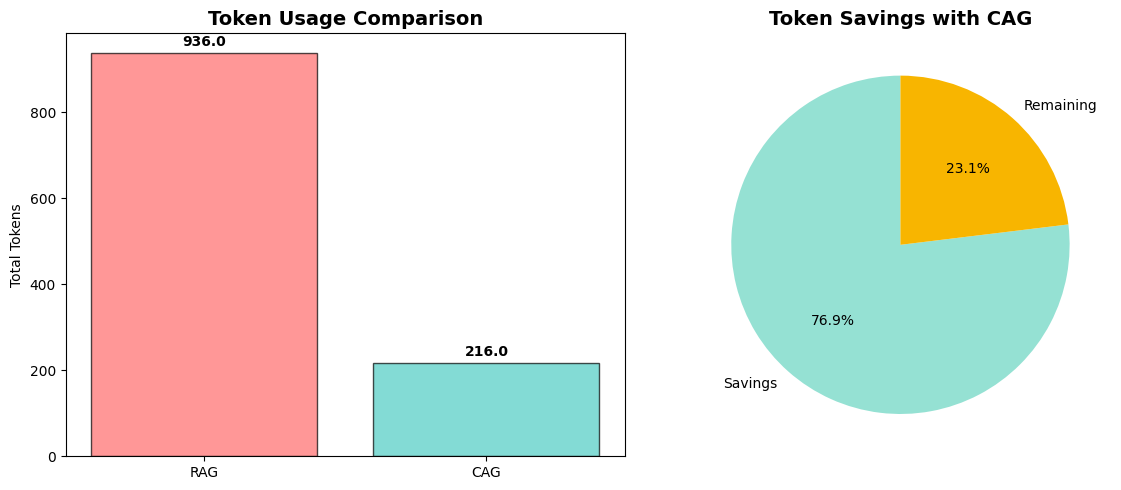


📊 Visualization Summary:
  • CAG reduces token usage by 76.9%
  • Total token savings: 720.0 tokens
  • RAG total tokens: 936.0
  • CAG total tokens: 216.0


In [ ]:
# Cell: RAG vs CAG Performance Comparison

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Simple RAG implementation for comparison
class SimpleRAG:
    def __init__(self, documents, model_name="all-MiniLM-L6-v2"):
        self.documents = documents
        self.embedder = SentenceTransformer(model_name)
        print("🔄 Encoding documents for RAG...")
        self.doc_embeddings = self.embedder.encode(documents)
        print("✅ RAG setup complete")

    def retrieve_and_generate(self, query, top_k=2):
        # Step 1: Retrieve relevant documents
        query_embedding = self.embedder.encode([query])
        similarities = cosine_similarity(query_embedding, self.doc_embeddings)[0]
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        retrieved_docs = [self.documents[i] for i in top_indices]

        # Step 2: Generate response (simulated - in reality this would call LLM)
        # Simulate generation with the retrieved context + query
        context = " ".join(retrieved_docs)
        generation_prompt = f"Context: {context}\nQuestion: {query}\nAnswer:"

        # Use our existing model for generation
        input_ids = tokenizer(generation_prompt, return_tensors="pt").input_ids.to(device)
        with torch.no_grad():
            output = model.generate(
                input_ids,
                max_new_tokens=50,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
        response = tokenizer.decode(output[0][input_ids.shape[1]:], skip_special_tokens=True)

        return response, retrieved_docs

# Performance comparison function
def compare_rag_vs_cag():
    print("🚀 RAG vs CAG Performance Comparison")
    print("=" * 50)

    # Prepare documents for RAG (split the document text into chunks)
    doc_chunks = doc_text.split('\n\n')  # Simple chunking by paragraphs
    doc_chunks = [chunk.strip() for chunk in doc_chunks if chunk.strip()]

    # Initialize RAG system
    rag_system = SimpleRAG(doc_chunks)

    # Test queries
    test_queries = [
        "Who is Ronan Takizawa?",
        "What are his main projects?",
        "What technologies has he worked with?",
        "What is his background?",
        "Where does he study?"
    ]

    print(f"\n📊 Testing with {len(test_queries)} queries...")
    print("-" * 50)

    # RAG Performance
    print("\n🔍 RAG Performance:")
    rag_responses = []
    rag_retrieved_docs = []

    for i, query in enumerate(test_queries, 1):
        print(f"\nQuery {i}: {query}")
        response, retrieved_docs = rag_system.retrieve_and_generate(query)
        rag_responses.append(response)
        rag_retrieved_docs.append(retrieved_docs)
        print(f"  💬 Response: {response[:100]}...")

    # CAG Performance
    print("\n\n⚡ CAG Performance:")
    cag_responses = []

    # Load our pre-computed cache
    loaded_cache = torch.load(os.path.join(cache_dir, "ronan_knowledge.cache"))

    for i, query in enumerate(test_queries, 1):
        print(f"\nQuery {i}: {query}")

        # Reset cache to clean state
        clean_up(loaded_cache, origin_len)

        # Generate response using cached knowledge
        input_ids = tokenizer(query + "\n", return_tensors="pt").input_ids.to(device)
        gen_ids = generate(model, input_ids, loaded_cache, max_new_tokens=50)
        response = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
        cag_responses.append(response)

        print(f"  💬 Response: {response[:100]}...")

    # Comparison Summary
    print("\n" + "=" * 50)
    print("📈 COMPARISON SUMMARY")
    print("=" * 50)

    # Cost simulation (approximate)
    print(f"\n💰 Cost Comparison (simulated):")
    # Assuming CAG processes knowledge once, RAG processes context every time
    knowledge_tokens = len(tokenizer(doc_text)['input_ids'])
    avg_query_tokens = np.mean([len(tokenizer(q)['input_ids']) for q in test_queries])

    rag_total_tokens = len(test_queries) * (knowledge_tokens + avg_query_tokens)
    cag_total_tokens = knowledge_tokens + (len(test_queries) * avg_query_tokens)

    print(f"  • RAG Total Tokens:  {rag_total_tokens:,} (reprocesses knowledge each time)")
    print(f"  • CAG Total Tokens:  {cag_total_tokens:,} (processes knowledge once)")
    print(f"  • Token Savings:     {((rag_total_tokens - cag_total_tokens) / rag_total_tokens * 100):.1f}%")

    print(f"\n🎯 Key Advantages of CAG:")
    print(f"  ✅ No retrieval latency or errors")
    print(f"  ✅ Consistent access to full knowledge base")
    print(f"  ✅ Significant cost reduction for repeated queries")
    print(f"  ✅ Simpler architecture (no retrieval system needed)")

    # Visualize results
    visualize_comparison(test_queries, rag_responses, cag_responses,
                        rag_total_tokens, cag_total_tokens, knowledge_tokens, avg_query_tokens)

def visualize_comparison(queries, rag_responses, cag_responses, rag_tokens, cag_tokens, knowledge_tokens, avg_query_tokens):
    """Create visualizations comparing RAG vs CAG performance"""

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create a figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # 1. Token Usage Comparison
    methods = ['RAG', 'CAG']
    token_counts = [rag_tokens, cag_tokens]
    colors = ['#FF6B6B', '#4ECDC4']

    bars = ax1.bar(methods, token_counts, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    ax1.set_title('Token Usage Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Total Tokens')
    ax1.ticklabel_format(style='plain', axis='y')

    # Add value labels on bars
    for bar, value in zip(bars, token_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(token_counts)*0.01,
                f'{value:,}', ha='center', va='bottom', fontweight='bold')

    # 2. Token Savings Visualization
    savings_percent = ((rag_tokens - cag_tokens) / rag_tokens * 100)
    wedges, texts, autotexts = ax2.pie([savings_percent, 100-savings_percent],
                                      labels=['Savings', 'Remaining'],
                                      colors=['#95E1D3', '#F8B500'],
                                      autopct='%1.1f%%', startangle=90)
    ax2.set_title('Token Savings with CAG', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\n📊 Visualization Summary:")
    print(f"  • CAG reduces token usage by {savings_percent:.1f}%")
    print(f"  • Total token savings: {rag_tokens - cag_tokens:,} tokens")
    print(f"  • RAG total tokens: {rag_tokens:,}")
    print(f"  • CAG total tokens: {cag_tokens:,}")

# Run the comparison
compare_rag_vs_cag()